In [5]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import os
import sys

from IPython.display import Image

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import plotly.express as px

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utilities import utils


DATA_PATH = utils.get_datapath('data')
MODEL_PATH = utils.get_datapath('model')
FIGURE_PATH = utils.get_datapath('figures')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Table of contents**<a id='toc0_'></a>    
- [**7. Model Evaluation**](#toc1_)    
- [Prepare Data](#toc2_)    
- [Evaluating Models Trained on TF-IDF](#toc3_)    
  - [Logisitic Regression Alone](#toc3_1_)    
    - [Classification Report](#toc3_1_1_)    
    - [AUC-ROC Curve](#toc3_1_2_)    
  - [Logisitic Regression + Dimensionality Reduction](#toc3_2_)    
    - [Classification Report](#toc3_2_1_)    
    - [Confusion Matrix](#toc3_2_2_)    
    - [AUC-ROC Curve](#toc3_2_3_)    
  - [Multinomial Naive Bayes Classifier](#toc3_3_)    
    - [Classification Report](#toc3_3_1_)    
    - [Confusion Matrix](#toc3_3_2_)    
    - [AUC-ROC Curve](#toc3_3_3_)    
  - [Random Forest](#toc3_4_)    
    - [Classification Report](#toc3_4_1_)    
    - [Confusion Matrix](#toc3_4_2_)    
    - [AUC-ROC Curve](#toc3_4_3_)    
- [Evaluating Models Trained on Ada Embeddings](#toc4_)    
  - [Logsitic Regression](#toc4_1_)    
    - [Classification Report](#toc4_1_1_)    
    - [Confusion Matrix](#toc4_1_2_)    
    - [AUC-ROC Curve](#toc4_1_3_)    
  - [Logsitic Regression and PCA Transformed Ada Embeddings](#toc4_2_)    
    - [Classification Report](#toc4_2_1_)    
    - [Confusion Matrix](#toc4_2_2_)    
    - [AUC-ROC Curve](#toc4_2_3_)    
- [Evaluating Predictive Ability of Lyrics in Hip Hop](#toc5_)    
  - [Setting Up the Data](#toc5_1_)    
  - [Logistic Regression and TF-IDF](#toc5_2_)    
    - [Classification Report](#toc5_2_1_)    
    - [AUC-ROC Curve](#toc5_2_2_)    
  - [Naive Bayes and TF-IDF](#toc5_3_)    
    - [Classification Report](#toc5_3_1_)    
    - [AUC-ROC Curve](#toc5_3_2_)    
- [Model Interpretation](#toc6_)    
  - [Logsitc Regression and TF-IDF Model Interpretation](#toc6_1_)    
    - [Word Importance for the Most Popular Songs](#toc6_1_1_)    
    - [Word Importance for the Least Popular Songs](#toc6_1_2_)    
- [Dimensionality Reduction of Ada Embeddings Using TSNE](#toc7_)    
  - [Visualizing the Dimensionality Reduced Ada Embeddings](#toc7_1_)    
- [Conclusion](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[**7. Model Evaluation**](#toc0_)

We will now evaluate how the models performed by looking at different metrics for precision and recall. This notebook will first be split up based on the type of text representation, either TF-IDF or Ada embeddings. 

We will specifically look at the:
- Accuracy
- Precsion 
- Recalll
- AUC-ROC

We will be using the `classification_report()` function from scikit-learn, along with generating AUC-ROC curves for each of the models. 


# <a id='toc2_'></a>[Prepare Data](#toc0_)

We will get the same train / test splits as the models were built by using the same random state. 

In [6]:
# Load the data
df = pd.read_csv(DATA_PATH / 'clean_lyrics_final.csv')

In [3]:
X=df[['cleaned_lyrics_stem', 'ada_embeddings']]
y=df['spotify_popularity_three_class']

# Create train and test splits and set a random state for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=33)

# Dividing up the raws lyrics and the embeddings.
X_train_lyrics = X_train['cleaned_lyrics_stem']
X_train_embeddings = utils.get_ada_embeddings(X_train['ada_embeddings'])

X_test_lyrics = X_test['cleaned_lyrics_stem']
X_test_embeddings = utils.get_ada_embeddings(X_test['ada_embeddings'])


In [4]:
X_train_lyrics.shape, X_test_lyrics.shape

((22848,), (5712,))

In [5]:
X_train_embeddings.shape, X_test_embeddings.shape

((22848, 1536), (5712, 1536))

In [6]:
# Check the test 
y_test.value_counts(normalize=True)

1    0.338936
0    0.337885
2    0.323179
Name: spotify_popularity_three_class, dtype: float64

# <a id='toc3_'></a>[Evaluating Models Trained on TF-IDF](#toc0_)

## <a id='toc3_1_'></a>[Logisitic Regression Alone](#toc0_)

In [7]:
# Load the model
model = utils.load_model(MODEL_PATH / 'log_reg_tfidf.pkl')

In [8]:
# Make predictions
predictions = model.best_estimator_.predict(X_test_lyrics)

### <a id='toc3_1_1_'></a>[Classification Report](#toc0_)

In [9]:
print(classification_report(y_test, predictions, target_names=['Low', 'Med', 'High']))

              precision    recall  f1-score   support

         Low       0.44      0.54      0.49      1930
         Med       0.38      0.30      0.34      1936
        High       0.42      0.41      0.42      1846

    accuracy                           0.42      5712
   macro avg       0.42      0.42      0.41      5712
weighted avg       0.42      0.42      0.41      5712



From this classification report we can see that the model struggles more with the medium popularity class. The model also seems to have better performance in predicting low popularity songs. 

<Figure size 800x800 with 0 Axes>

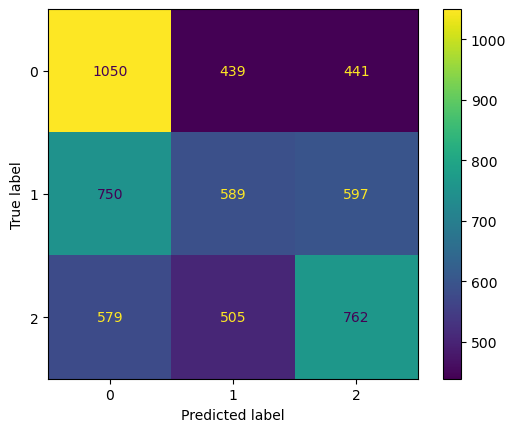

In [10]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
plt.figure(figsize=(8,8))
disp.plot()
plt.show()

The confusion matrix also shows that the model is misclassifying the medium class as low popularity more than high popularity.

### <a id='toc3_1_2_'></a>[AUC-ROC Curve](#toc0_)

In [11]:
y_score = model.predict_proba(X_test_lyrics)
n_classes = len(y_test.unique())

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

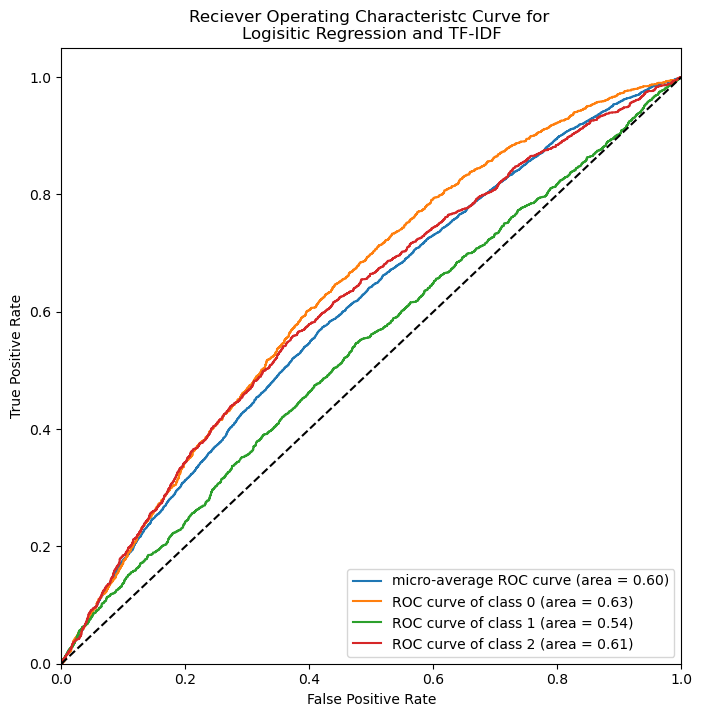

In [12]:
utils.generate_multi_class_roc(y_score, y_onehot_test, n_classes, 'Logisitic Regression and TF-IDF')

This AUC-ROC adds further support to the idea that the model is struggling to identify the medium popularity class. 

## <a id='toc3_2_'></a>[Logisitic Regression + Dimensionality Reduction](#toc0_)

In [38]:
# Load the model
model = utils.load_model(MODEL_PATH / 'log_reg_tfidf_nmf.pkl')

In [39]:
predictions = model.best_estimator_.predict(X_test_lyrics)

### <a id='toc3_2_1_'></a>[Classification Report](#toc0_)

In [40]:
print(classification_report(y_test, predictions, target_names=['Low', 'Med', 'High']))

              precision    recall  f1-score   support

         Low       0.42      0.56      0.48      1930
         Med       0.36      0.24      0.29      1936
        High       0.41      0.41      0.41      1846

    accuracy                           0.40      5712
   macro avg       0.40      0.40      0.39      5712
weighted avg       0.40      0.40      0.39      5712



A simlar trend of struggling with predicting the middle popularity class is evident. 

### <a id='toc3_2_2_'></a>[Confusion Matrix](#toc0_)

<Figure size 800x800 with 0 Axes>

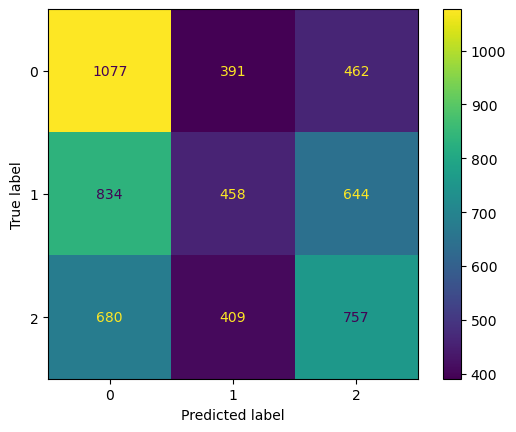

In [41]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
plt.figure(figsize=(8,8))
disp.plot()
plt.show()

The model is once again predicting many of the middle popularity class as low popularity.

### <a id='toc3_2_3_'></a>[AUC-ROC Curve](#toc0_)

In [42]:
y_score = model.predict_proba(X_test_lyrics)
n_classes = len(y_test.unique())

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

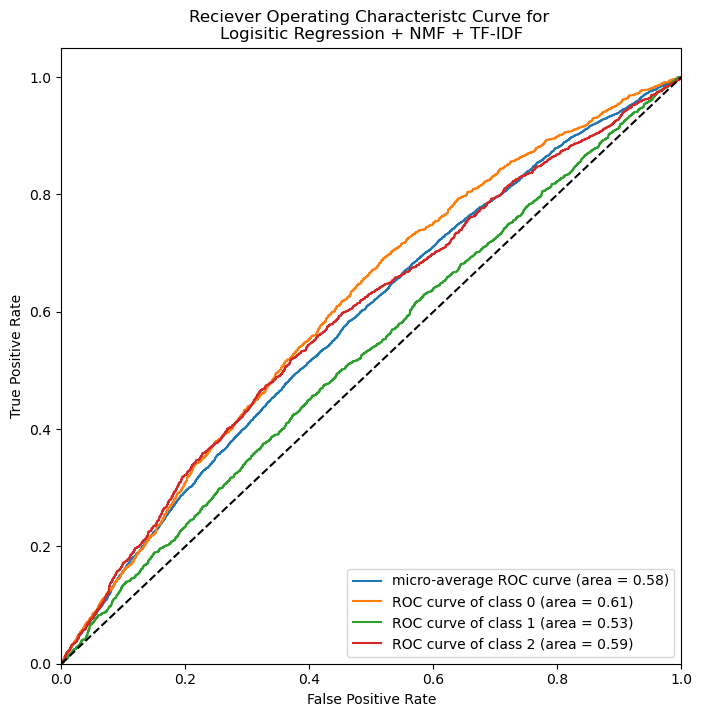

In [43]:
utils.generate_multi_class_roc(y_score, y_onehot_test, n_classes, 'Logisitic Regression + NMF + TF-IDF')

The ROC curve seems to be similar with the model struggling the most to classify medium popularity songs. 

## <a id='toc3_3_'></a>[Multinomial Naive Bayes Classifier](#toc0_)

In [44]:
# Load the model
model = utils.load_model(MODEL_PATH / 'naive_bayes_tf_idf.pkl')

In [45]:
predictions = model.best_estimator_.predict(X_test_lyrics)

### <a id='toc3_3_1_'></a>[Classification Report](#toc0_)

In [46]:
print(classification_report(y_test, predictions, target_names=['Low', 'Med', 'High']))

              precision    recall  f1-score   support

         Low       0.43      0.55      0.48      1930
         Med       0.39      0.23      0.29      1936
        High       0.42      0.48      0.45      1846

    accuracy                           0.42      5712
   macro avg       0.41      0.42      0.41      5712
weighted avg       0.41      0.42      0.41      5712



This Naive Bayes classifier demonstrated similar performance to the first logistic regression model. 

### <a id='toc3_3_2_'></a>[Confusion Matrix](#toc0_)

<Figure size 800x800 with 0 Axes>

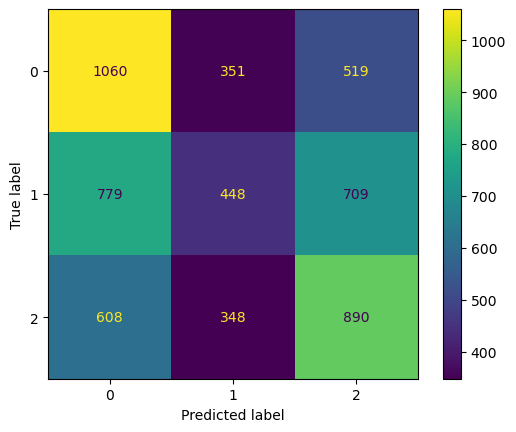

In [47]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
plt.figure(figsize=(8,8))
disp.plot()
plt.show()

This model seems to be misclassifying the medium popularity class equally as either low or high popularity. 

### <a id='toc3_3_3_'></a>[AUC-ROC Curve](#toc0_)

In [48]:
y_score = model.predict_proba(X_test_lyrics)
n_classes = len(y_test.unique())

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

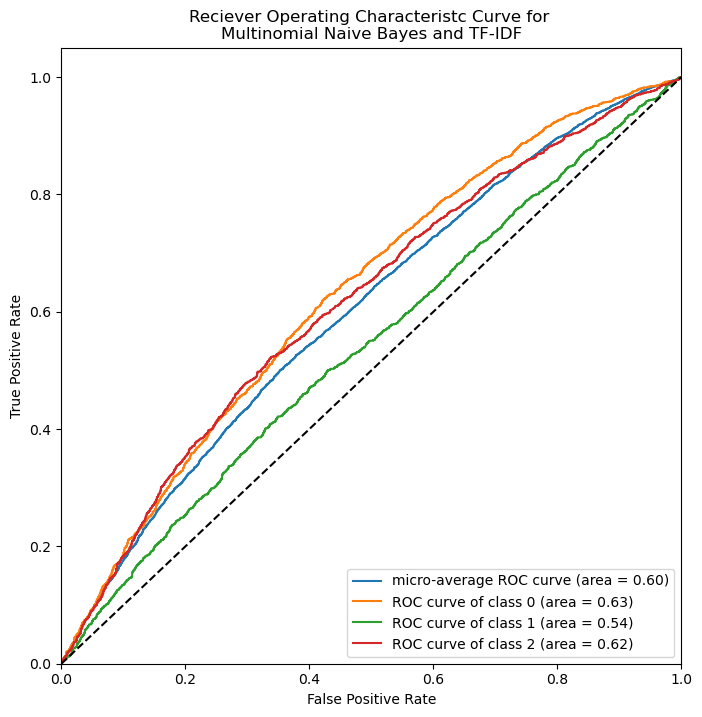

In [49]:
utils.generate_multi_class_roc(y_score, y_onehot_test, n_classes, 'Multinomial Naive Bayes and TF-IDF')

## <a id='toc3_4_'></a>[Random Forest](#toc0_)

In [50]:
# Load the model
model = utils.load_model(MODEL_PATH / 'random_forest_tf_idf_v1.pkl')

In [51]:
predictions = model.best_estimator_.predict(X_test_lyrics)

### <a id='toc3_4_1_'></a>[Classification Report](#toc0_)

In [52]:
print(classification_report(y_test, predictions, target_names=['Low', 'Med', 'High']))

              precision    recall  f1-score   support

         Low       0.42      0.63      0.51      1930
         Med       0.39      0.23      0.29      1936
        High       0.44      0.40      0.42      1846

    accuracy                           0.42      5712
   macro avg       0.42      0.42      0.41      5712
weighted avg       0.42      0.42      0.41      5712



Once again the model is struggling to identify what makes the middle class unique. 

### <a id='toc3_4_2_'></a>[Confusion Matrix](#toc0_)

<Figure size 800x800 with 0 Axes>

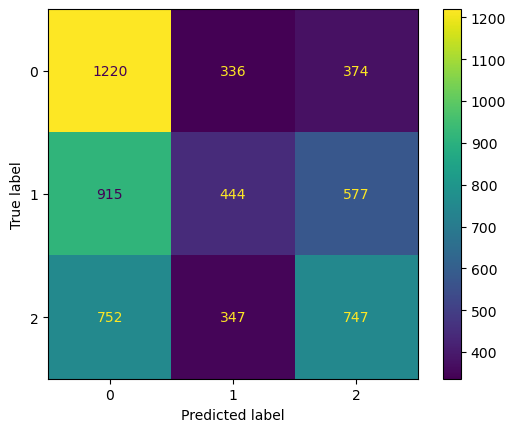

In [53]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
plt.figure(figsize=(8,8))
disp.plot()
plt.show()

### <a id='toc3_4_3_'></a>[AUC-ROC Curve](#toc0_)

In [26]:
y_score = model.predict_proba(X_test_lyrics)
n_classes = len(y_test.unique())

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

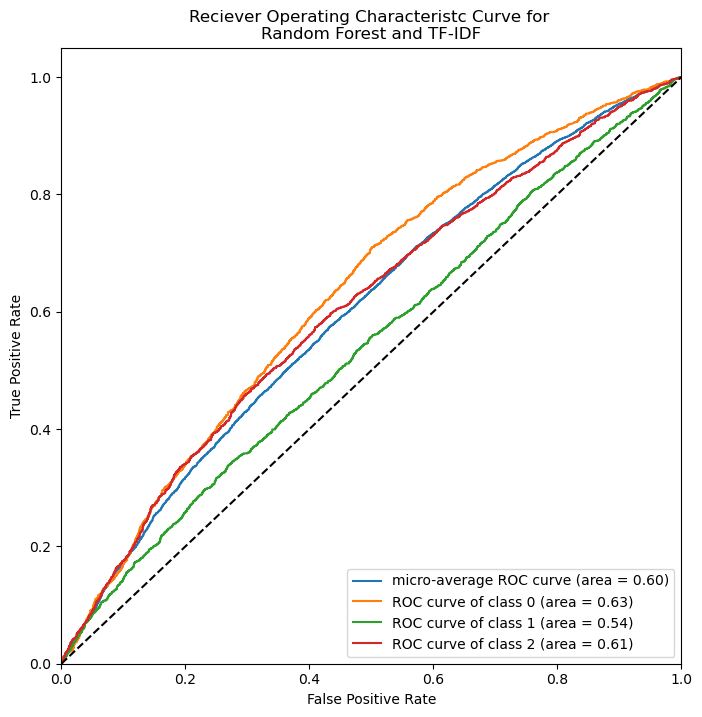

In [27]:
utils.generate_multi_class_roc(y_score, y_onehot_test, n_classes, 'Random Forest and TF-IDF')

---

# <a id='toc4_'></a>[Evaluating Models Trained on Ada Embeddings](#toc0_)

## <a id='toc4_1_'></a>[Logsitic Regression](#toc0_)

In [54]:
# Load the model
model = utils.load_model(MODEL_PATH / 'log_reg_ada.pkl')

In [55]:
predictions = model.best_estimator_.predict(X_test_embeddings)

### <a id='toc4_1_1_'></a>[Classification Report](#toc0_)

In [56]:
print(classification_report(y_test, predictions, target_names=['Low', 'Med', 'High']))

              precision    recall  f1-score   support

         Low       0.45      0.68      0.54      1930
         Med       0.43      0.42      0.43      1936
        High       0.52      0.26      0.34      1846

    accuracy                           0.45      5712
   macro avg       0.47      0.45      0.44      5712
weighted avg       0.47      0.45      0.44      5712



With the Ada embeddings we gain an increase in accuracy, but we lose our predictive ability for the high popularity class. The issue with identifying the medium popularity class has been reduced. 

### <a id='toc4_1_2_'></a>[Confusion Matrix](#toc0_)

<Figure size 800x800 with 0 Axes>

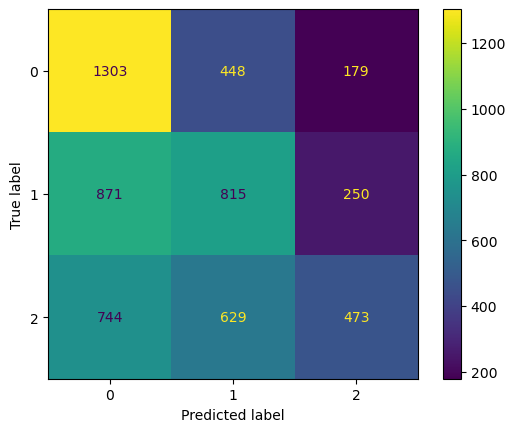

In [57]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
plt.figure(figsize=(8,8))
disp.plot()
plt.show()

### <a id='toc4_1_3_'></a>[AUC-ROC Curve](#toc0_)

In [31]:
y_score = model.predict_proba(X_test_embeddings)
n_classes = len(y_test.unique())

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

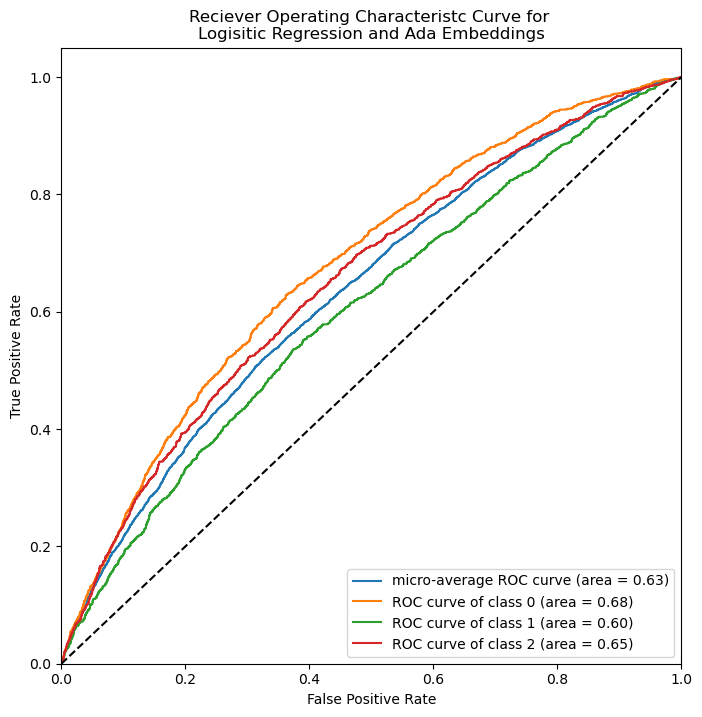

In [32]:
utils.generate_multi_class_roc(y_score, y_onehot_test, n_classes, 'Logisitic Regression and Ada Embeddings')

We can see from the AUC-ROC curve the ability of the model to predict medium popularity has improved compared to the models with the TF-IDF vectorized lyrics as input. 

## <a id='toc4_2_'></a>[Logsitic Regression and PCA Transformed Ada Embeddings](#toc0_)

In [58]:
# Load the model
model = utils.load_model(MODEL_PATH / 'log_reg_ada_pca.pkl')

In [59]:
predictions = model.best_estimator_.predict(X_test_embeddings)

### <a id='toc4_2_1_'></a>[Classification Report](#toc0_)

In [60]:
print(classification_report(y_test, predictions, target_names=['Low', 'Med', 'High']))

              precision    recall  f1-score   support

         Low       0.43      0.60      0.50      1930
         Med       0.40      0.23      0.29      1936
        High       0.43      0.44      0.43      1846

    accuracy                           0.42      5712
   macro avg       0.42      0.42      0.41      5712
weighted avg       0.42      0.42      0.41      5712



When we use PCA to transform the Ada embeddings we lose the ability to distinguish the medium popularity songs. This could mean that the Ada embeddings provide information that is important in classifying the medium popularity songs, as PCA reduces the dimensionality of the embeddings.

### <a id='toc4_2_2_'></a>[Confusion Matrix](#toc0_)

<Figure size 800x800 with 0 Axes>

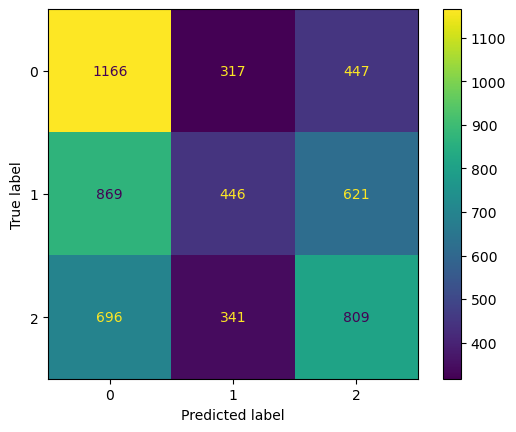

In [61]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
plt.figure(figsize=(8,8))
disp.plot()
plt.show()

### <a id='toc4_2_3_'></a>[AUC-ROC Curve](#toc0_)

In [62]:
y_score = model.predict_proba(X_test_embeddings)
n_classes = len(y_test.unique())

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

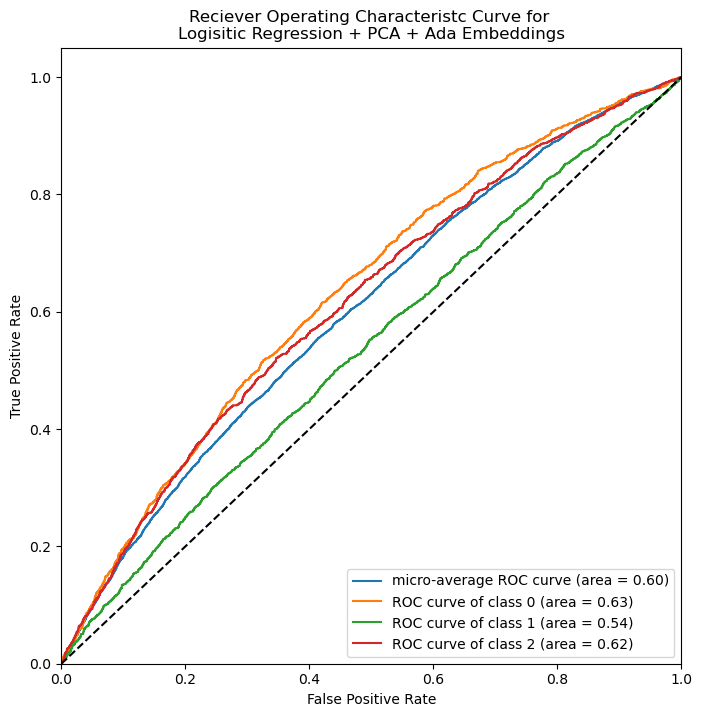

In [63]:
utils.generate_multi_class_roc(y_score, y_onehot_test, n_classes, 'Logisitic Regression + PCA + Ada Embeddings')

We can see from the ROC curve for the medium class popularity we lose the ability to classify this class effectively. 

# <a id='toc5_'></a>[Evaluating Predictive Ability of Lyrics in Hip Hop](#toc0_)

## <a id='toc5_1_'></a>[Setting Up the Data](#toc0_)
We first need to recreate the splits we used for training.

In [7]:
# Subset the dataset.
hip_hop_df = df[
    df['genre'] == 'hip hop'
]


X=hip_hop_df[['cleaned_lyrics_stem']]
y=hip_hop_df['spotify_popularity_three_class']

# Create train and test splits and set a random state for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=33)

# Dividing up the raws lyrics and the embeddings.
X_train_lyrics = X_train['cleaned_lyrics_stem']
X_test_lyrics = X_test['cleaned_lyrics_stem']


## <a id='toc5_2_'></a>[Logistic Regression and TF-IDF](#toc0_)

In [8]:
# Load the model
model = utils.load_model(MODEL_PATH / 'log_reg_tfidf_hip_hop.pkl')

In [9]:
predictions = model.best_estimator_.predict(X_test_lyrics)

### <a id='toc5_2_1_'></a>[Classification Report](#toc0_)

In [10]:
print(classification_report(y_test, predictions, target_names=['Low', 'Med', 'High']))

              precision    recall  f1-score   support

         Low       0.43      0.76      0.55       888
         Med       0.37      0.21      0.27       777
        High       0.42      0.22      0.29       692

    accuracy                           0.42      2357
   macro avg       0.41      0.40      0.37      2357
weighted avg       0.41      0.42      0.38      2357



We can see that when we subset the data to hip hop our model still performs similarily.

<Figure size 800x800 with 0 Axes>

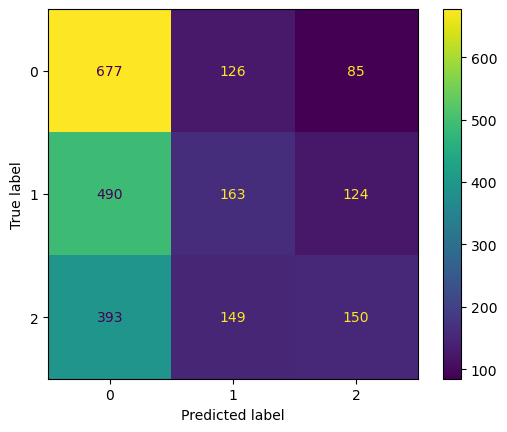

In [11]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
plt.figure(figsize=(8,8))
disp.plot()
plt.show()

### <a id='toc5_2_2_'></a>[AUC-ROC Curve](#toc0_)

In [12]:
y_score = model.predict_proba(X_test_lyrics)
n_classes = len(y_test.unique())

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

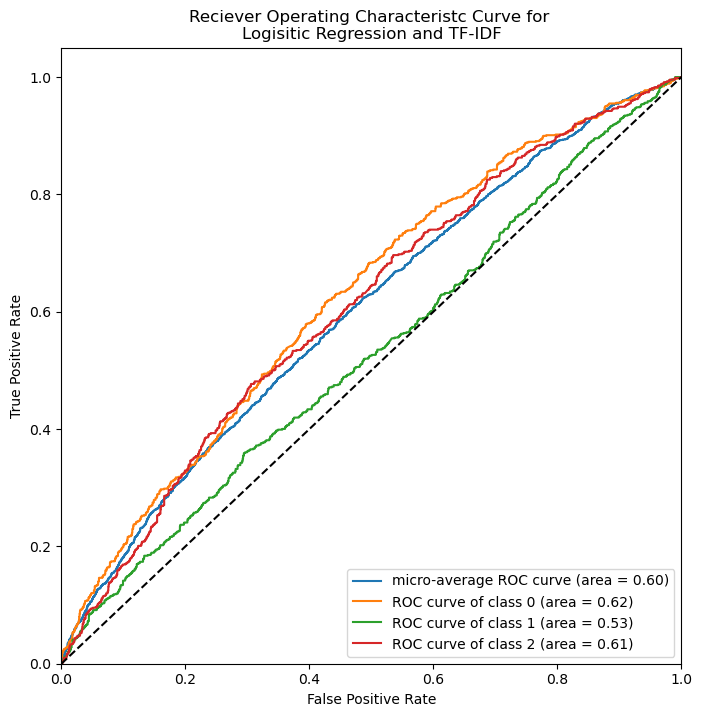

In [13]:
utils.generate_multi_class_roc(y_score, y_onehot_test, n_classes, 'Logisitic Regression and TF-IDF')

## <a id='toc5_3_'></a>[Naive Bayes and TF-IDF](#toc0_)

In [14]:
# Load the model
model = utils.load_model(MODEL_PATH / 'mnb_tfidf_hip_hop.pkl')

In [15]:
predictions = model.best_estimator_.predict(X_test_lyrics)

### <a id='toc5_3_1_'></a>[Classification Report](#toc0_)

In [16]:
print(classification_report(y_test, predictions, target_names=['Low', 'Med', 'High']))

              precision    recall  f1-score   support

         Low       0.45      0.69      0.54       888
         Med       0.38      0.23      0.29       777
        High       0.41      0.31      0.35       692

    accuracy                           0.42      2357
   macro avg       0.41      0.41      0.39      2357
weighted avg       0.41      0.42      0.40      2357



The multinomial Naive Bayes classifier also performs similarily when we subset the dataset.

<Figure size 800x800 with 0 Axes>

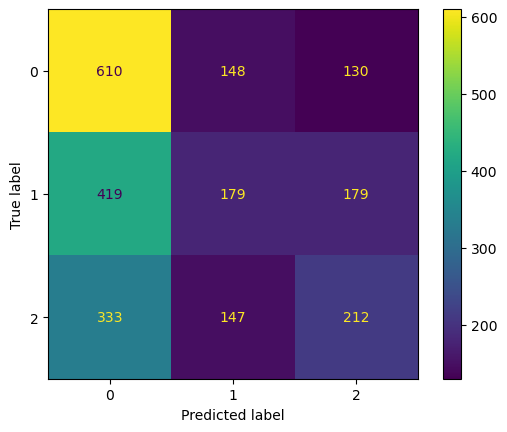

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
plt.figure(figsize=(8,8))
disp.plot()
plt.show()

### <a id='toc5_3_2_'></a>[AUC-ROC Curve](#toc0_)

In [18]:
y_score = model.predict_proba(X_test_lyrics)
n_classes = len(y_test.unique())

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

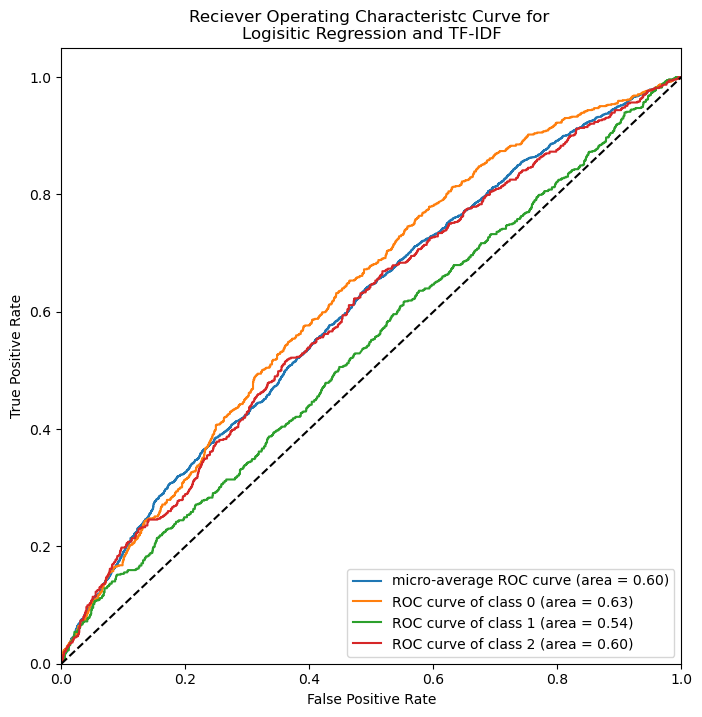

In [19]:
utils.generate_multi_class_roc(y_score, y_onehot_test, n_classes, 'Logisitic Regression and TF-IDF')

---

# <a id='toc6_'></a>[Model Interpretation](#toc0_)

After evaluating the model performance, we decided to try and see which words were weighted more heavily for predicting a songs popularity. We will mainly be focusing on interpreting the models that used the TF-IDF vectors as there is no easy way to interpret the document embeddings from OpenAI. Additionally, we will just look at the words that are most important for predicting `High` and `Low` popularity songs, as all the models have demonstrated poorer performance (AUC close to 0.5) for determining `Medium` popularity songs.

We wiil first look at the logisitic regression model and look at the top predicting words for each class based on the model coefficients. 

## <a id='toc6_1_'></a>[Logsitc Regression and TF-IDF Model Interpretation](#toc0_)

The first step for interpretation is to get the words that were used in the vectorizer. 

In [3]:
# Load the model
model = utils.load_model(MODEL_PATH / 'log_reg_tfidf.pkl')

In [4]:
# Get the words in the vectorizer.
words = model.best_estimator_.named_steps['tfidf'].get_feature_names_out()

In [5]:
len(words)

2236

We see that there are 2236 tokens in the vectorizer. We also need to get the model coefficients.

In [6]:
coefficients = model.best_estimator_.named_steps['log_reg'].coef_

In [7]:
coefficients.shape

(3, 2236)

In [8]:
coefficients

array([[ 0.02581674,  0.28094972, -0.2379321 , ...,  0.09981127,
         0.00701805, -0.01167028],
       [-0.13652774, -0.10380281, -0.03213235, ..., -0.11781754,
         0.11486694,  0.07634035],
       [ 0.110711  , -0.1771469 ,  0.27006445, ...,  0.01800627,
        -0.12188498, -0.06467007]])

In [9]:
# The order of the classes for the coefficients.
model.best_estimator_.named_steps['log_reg'].classes_

array([0, 1, 2])

We can see that the model has coefficients for each of our three classes, which is demonstrated by the shape of the coefficients. This is the case as logistic regression for multi-class problems in scikit-learn create classifiers for each class. Each classifier treats the class as the positive class and the other classes as the negative class. This reduces the problem to a binary classification for each of the classifiers. 

We can still see which words are most important for determining each class by looking at the coefficients for each row in `coefficients`. 

### <a id='toc6_1_1_'></a>[Word Importance for the Most Popular Songs](#toc0_)

In [10]:
# Extract the songs for the most popular songs.
word_importance_most_popular_songs = pd.DataFrame(
    {
        'Word':words,
        'Coefficients':coefficients[2]
    }
).sort_values(by='Coefficients', ascending=False)

In [11]:
# Calculate the odds for each song. 
word_importance_most_popular_songs['Odds'] = np.exp(word_importance_most_popular_songs['Coefficients'])

In [12]:
word_importance_most_popular_songs[:20]

Word  Coefficients      Odds
2213    yeah      0.417526  1.518201
672     feel      0.411589  1.509214
1280    need      0.407777  1.503471
1552  rememb      0.395063  1.484478
1329     ooh      0.394166  1.483147
1320      oh      0.373219  1.452402
917     hold      0.368025  1.444878
2107   wanna      0.367957  1.444780
104      bad      0.364590  1.439924
579    drunk      0.350519  1.419804
2171    wish      0.347209  1.415112
1421   pleas      0.337357  1.401239
958       id      0.333473  1.395807
94      away      0.332091  1.393880
1305  nothin      0.327473  1.387457
987     isnt      0.314828  1.370024
1231     mmm      0.313925  1.368787
1037    kiss      0.311294  1.365190
1937  talkin      0.309808  1.363163
1049      la      0.304569  1.356040

In [18]:
fig = px.bar(
    word_importance_most_popular_songs[:20],
    x='Word',
    y='Odds',
    width=600, height=600,
    template='xgridoff',
    title='<b>Top 20 Words For Predicting a Popular Song<b>'
)

fig.update_traces(
    marker_color='rgb(30, 215, 96)'
)

fig.update_xaxes(tickangle=45)

fig.update_layout(
        {
            'plot_bgcolor': 'rgba(14,17,23,255)',
            'paper_bgcolor': 'rgba(14,17,23,255)',
            'font_color' : 'rgba(255, 255, 255, 255)'
        },  
        yaxis_title='<b>Odds<b>',
        xaxis_title='<b>Words<b>',
        showlegend=False,
        yaxis_range=[1.2, 1.6]

)

config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 600,
    'width': 600,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}


fig.show(config=config)

We can see that most of the words have positive feelings associated with them and many deal with physical contact (`feel`, `hold` and `kiss`). Additionally, certain words may look strange as they were stemmed, for example `remember` was turned into `remember`. Also mentioning `la`, which was originally `LA` (transformed during text cleaning stage), seems to also increase the popularity of a song. 

In [63]:
with open(FIGURE_PATH / 'Top_20_words_for_popular_songs.pkl', 'wb') as file:
    joblib.dump(fig, file)

### <a id='toc6_1_2_'></a>[Word Importance for the Least Popular Songs](#toc0_)

In [14]:
# Extract the coefficients for the least popular songs.
word_importance_least_popular_songs = pd.DataFrame(
    {
        'Word':words,
        'Coefficients':coefficients[0]
    }
).sort_values(by='Coefficients', ascending=False)

In [15]:
# Calculate the odds for each word. 
word_importance_least_popular_songs['Odds'] = np.exp(word_importance_least_popular_songs['Coefficients'])

In [16]:
word_importance_least_popular_songs[:20]

Word  Coefficients      Odds
556    drake      0.793632  2.211413
1555   remix      0.639110  1.894793
2206      ya      0.604805  1.830895
1518  rapper      0.527801  1.695201
37      aint      0.527603  1.694865
966     imma      0.497864  1.645203
2204      x2      0.485299  1.624660
470      cuz      0.466855  1.594969
852    gucci      0.456691  1.578840
837    green      0.445998  1.562048
56     angel      0.436197  1.546813
178    black      0.433053  1.541958
1358   paper      0.427238  1.533018
203     bone      0.420293  1.522407
1240   money      0.419407  1.521060
2209    yall      0.416554  1.516726
2172     wit      0.396157  1.486102
1516     rap      0.390436  1.477624
776     game      0.376344  1.456948
176    bitch      0.367641  1.444323

In [17]:
fig = px.bar(
    word_importance_least_popular_songs[:20],
    x='Word',
    y='Odds',
    width=600, height=600,
    template='xgridoff',
    title='<b>Top 20 Words For Predicting an Unpopular Song<b>'
)

fig.update_traces(
    marker_color='rgb(30, 215, 96)'
)

fig.update_xaxes(tickangle=45)

fig.update_layout(
        {
            'plot_bgcolor': 'rgba(14,17,23,255)',
            'paper_bgcolor': 'rgba(14,17,23,255)',
            'font_color' : 'rgba(255, 255, 255, 255)'
        },  
        yaxis_title='<b>Odds<b>',
        xaxis_title='<b>Words<b>',
        showlegend=False,
        yaxis_range=[1.2, 2.2]

)

config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 600,
    'width': 600,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

fig.show(config=config)

Shockingly we can see that mentioning `Drake` in a song increases the odds of the model classifying the song as an unpopular song. This could be attributed to inexperienced "Soundcloud Rappers" commenting on  `Drake` in their songs. This is supported as some of the other words that increase the odds of an unpopular song also are correlated to generic sounding novice rapper themes such as `money` and `green`. 

In [68]:
with open(FIGURE_PATH / 'Top_20_words_for_unpopular_songs.pkl', 'wb') as file:
    joblib.dump(fig, file)

# <a id='toc7_'></a>[Dimensionality Reduction of Ada Embeddings Using TSNE](#toc0_)

Here we will provide some post modelling analysis of the Ada embeddings to see if we can understand why our models are struggling with classifying the correct classes. 

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
df = pd.read_csv(DATA_PATH / 'clean_lyrics_final.csv')

In [ ]:
ada_embeddings = utils.get_ada_embeddings(df['ada_embeddings'])

In [ ]:
tsne = TSNE(n_components=3, n_jobs=-1)

transformed_embeddings = tsne.fit_transform(ada_embeddings)

In [ ]:
with open(DATA_PATH / 'ada_embeddings_tsne.pkl', 'wb') as file:
    joblib.dump(transformed_embeddings, file)

## <a id='toc7_1_'></a>[Visualizing the Dimensionality Reduced Ada Embeddings](#toc0_)

In [ ]:
with open(DATA_PATH / 'ada_embeddings_tsne.pkl', 'rb') as file:
    transformed_embeddings = joblib.load(file)

In [ ]:
transformed_embeddings.shape

(28560, 3)

In [ ]:
df['tsne_component_1'] = transformed_embeddings[:,0]
df['tsne_component_2'] = transformed_embeddings[:,1]
df['tsne_component_3'] = transformed_embeddings[:,2]



In [ ]:
def convert_to_text(popularity_class):
    if popularity_class == 0:
        return 'Low'
    elif popularity_class == 1:
        return 'Medium'
    elif popularity_class == 2:
        return 'High'

In [ ]:
df['Spotify Popularity Class'] = df['spotify_popularity_three_class'].apply(convert_to_text)

In [ ]:
tsne_df = df[
    (df['tsne_component_1'] < 70) 
    &
    (df['tsne_component_1'] > -80)
    &
    (df['tsne_component_1'] < 70)
    & 
    (df['tsne_component_1'] > -70)

]

In [ ]:
color_map = {'Low':'white', 'Medium':'gray', 'High':'rgb(30, 215, 96)'}


fig = px.scatter(
        tsne_df,
        y='tsne_component_2',
        x='tsne_component_1',
        width=1000, height=1000,
        color='Spotify Popularity Class',
        template='xgridoff',
        hover_data=['title', 'primary_artist'],
        color_discrete_map=color_map,
        title='<b>Dimensionality Reduction of Ada Embeddings With TSNE<b>',
        opacity=0.5,
        category_orders={'Spotify Popularity Class': ['High', 'Medium', 'Low'] }
        )


fig.update_traces(
    textposition='top center',
    marker = dict(
        size=3
    )
)

fig.update_layout(
        {
            'plot_bgcolor': 'rgba(14,17,23,255)',
            'paper_bgcolor': 'rgba(14,17,23,255)',
            'font_color' : 'rgba(255, 255, 255, 255)'
        },  
        font=dict(
                size=12,
        ),
 
        yaxis_title='Component 2',
        xaxis_title='Component 1',
    )

fig.show()

We can see from this plot of the first two dimensions of the TSNE, there is little separation between the songs in terms of song popularity. This could help explain the difficulties the model is having in differentiating between the three classes.

# <a id='toc8_'></a>[Conclusion](#toc0_)

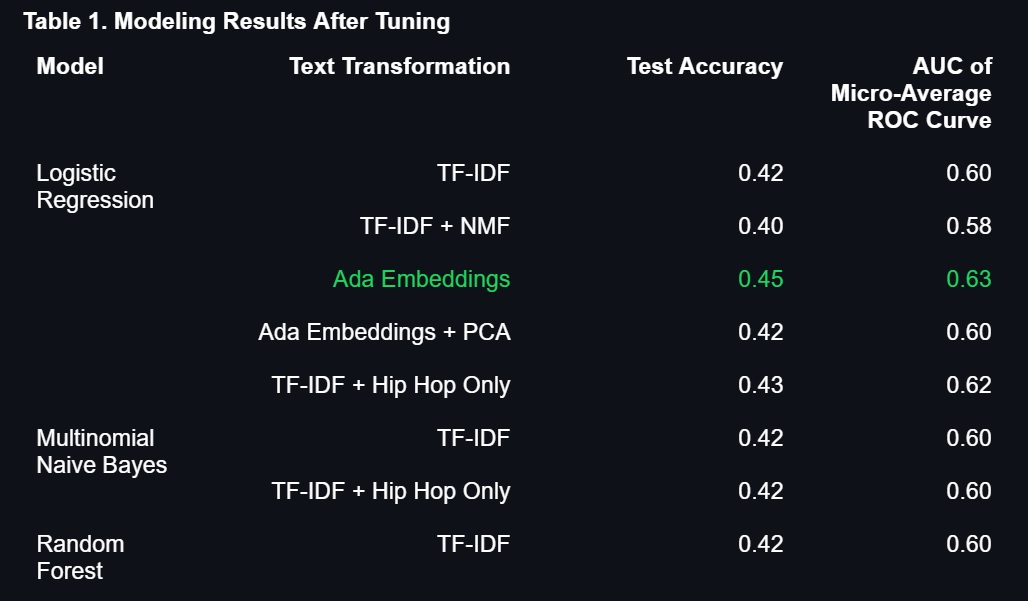

In [20]:
Image(filename=FIGURE_PATH / 'model_eval_summary.jpg')

The above is a summary of the models in terms of their accuracy and the micro-averaged AUC. We can see from all these values that we have only managed to create many weak classifiers, but even these weak classifiers were able to provide some insight into high popularity and low popularity lyrics. This was shown by interpreting the coefficients of the logistic regression model trained on TF-IDF vectorized lyrics. 

Unfortunately, subsetting the data to contain only hip hop songs did not increase the performance of the model. Even with these results we feel that controlling for genre will be ideal once we get more data, as this could reduce the noise introduced by vocabularies from other genres. 

Most of the models seemed to have issues with predicting the medium popularity class. This could be due to songs in the medium popularity class having many similarities to the high and low popularity class. The Ada embeddings seemed to contain information that helped with the classifying the medium popularity class. This idea was supported when we transformed the Ada embeddings with PCA and the ability to classify the medium popularity class dropped. By performing this dimensionality reduction we removed some of the information that the original Ada embeddings were providing. 

Similarily, when we performed TSNE on the Ada embeddings we found that there was major overlap between the popularity classes. This large overlap could be one reason why our models are struggling with differentiating between the classes. 

These findings demonstrate that song lyrics provides some information in determining popularity of a song, but a majority of the information necessary to predict popularity may be in other features.